# Download Dataset

https://www.kaggle.com/arunrk7/surface-crack-detection

In [ ]:
import os


os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection

 97% 225M/233M [00:02<00:00, 116MB/s] 
100% 233M/233M [00:02<00:00, 110MB/s]


In [ ]:
!unzip -q surface-crack-detection.zip

# Install alibi_detect

In [ ]:
!pip -q install alibi_detect

     |████████████████████████████████| 163kB 19.7MB/s 
     |████████████████████████████████| 2.2MB 15.2MB/s 
     |████████████████████████████████| 870kB 40.4MB/s 
     |████████████████████████████████| 3.3MB 49.2MB/s 


# Import Packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.models.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

%config InlineBackend.figure_format='retina'

# Split Dataset

In [ ]:
pos_list = glob('Positive/*.jpg')
neg_list = glob('Negative/*.jpg')

In [ ]:
!unzip -q Test_Images.zip

In [ ]:
pos_random_list = glob('Positive_test/*.jpg')
neg_random_list = glob('Negative_test/*.jpg')

In [ ]:
pos_train, pos_test = train_test_split(pos_list, test_size=0.2, random_state=821)
pos_train, pos_val = train_test_split(pos_train, test_size=0.25, random_state=821)

neg_train, neg_test = train_test_split(neg_list, test_size=0.2, random_state=821)
neg_train, neg_val = train_test_split(neg_train, test_size=0.25, random_state=821)

# Load Normal Images

- Negative: normal images
- Positive: crack images

In [ ]:
def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths:
      try:
        img = Image.open(fname).convert('RGB')
        if(resize): img = img.resize((64, 64))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

In [ ]:
x_train = img_to_np(neg_train)
x_train = x_train.astype(np.float32) / 255

print(x_train.shape)

(12000, 64, 64, 3)


In [ ]:
pos_random = img_to_np(pos_random_list)
pos_random = pos_random.astype(np.float32) / 255

neg_random = img_to_np(neg_random_list)
neg_random = neg_random.astype(np.float32) / 255

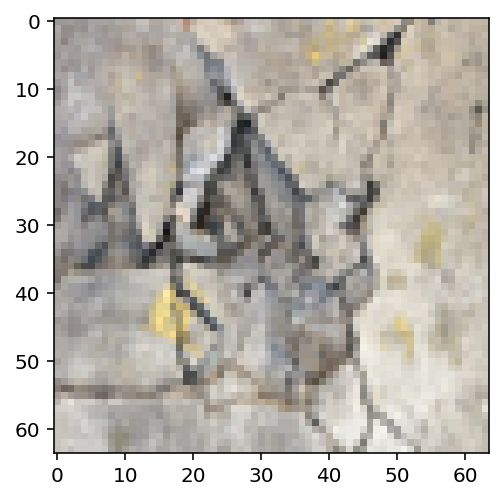

In [ ]:
plt.imshow(pos_random[0])
plt.show()

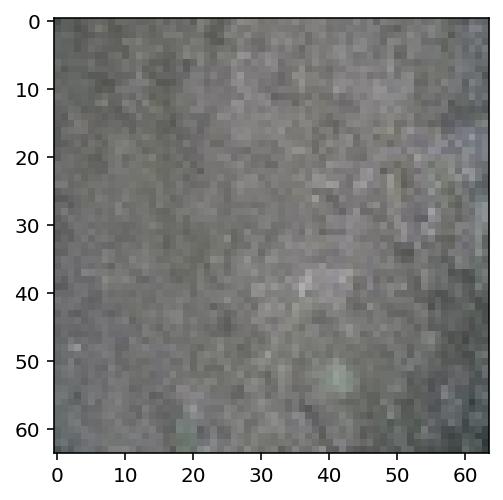

In [ ]:
plt.imshow(neg_random[0])
plt.show()

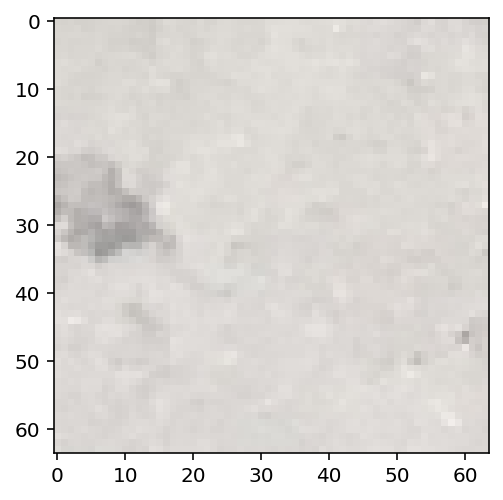

In [ ]:
plt.imshow(x_train[821])
plt.show()

# Build Model

In [ ]:
latent_dim = 1024

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.005,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

# Train

In [ ]:
len(x_train)

12000

In [ ]:
from itertools import product


d_params = {
    'optimizer': [tf.keras.optimizers.Adam(learning_rate=.0001), tf.keras.optimizers.Adam(learning_rate=.001)],
    'cov_elbo': [dict(sim=.05), dict(cov_diag=None)],
    'epochs': [30, 40, 50]
}
params = list(product(*d_params.values()))
params = [{'optimizer': param[0], 'cov_elbo': param[1], 'epochs': param[2]} for param in params]
len(params)

12

In [ ]:
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

x_train_light = img_to_np(neg_train[:1000])
x_train_light = x_train_light.astype(np.float32) / 255

df_valid = pd.DataFrame({'fileNm': [*pos_val[:500], *neg_val[:500]]})
df_valid['target'] = df_valid['fileNm'].map(lambda x: np.where('Positive' in x, 1, 0))

x_val = img_to_np(df_valid['fileNm'])
x_val = x_val.astype(np.float32) / 255

results = {'param': [], 'threshold': [], 'val_acc': [], 'val_recall': []}
for param in tqdm(params):
  od.fit(
      x_train_light,
      loss_fn=elbo,
      optimizer=param['optimizer'],
      cov_elbo=param['cov_elbo'],
      epochs=param['epochs'],
      verbose=False
  )

  od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
    )
  df_valid['score'] = od_preds['data']['instance_score']

  score_top = df_valid.query('target == 0')['score'].max()
  score_bottom = df_valid.query('target == 1')['score'].min()
  thresholds = np.linspace(score_bottom, score_top, 200)
  
  d_preds = dict({})
  for threshold in thresholds:
    d_preds[f'{threshold}'] = df_valid['score'].map(lambda x: np.where(x >= threshold, 1, 0)).tolist()
    
  d_metrics = {'threshold': [], 'accuracy': [], 'recall': []}
  y_true = df_valid['target']

  for threshold in thresholds:
    y_pred = d_preds[f'{threshold}']
    d_metrics['threshold'].append(threshold)
    d_metrics['accuracy'].append(accuracy_score(y_true=y_true, y_pred=y_pred))
    d_metrics['recall'].append(recall_score(y_true=y_true, y_pred=y_pred))
      
  df_metrics = pd.DataFrame(d_metrics)
  opt_idx = np.argmax(np.sum(df_metrics.drop(columns=['threshold']), axis=1))
  opt_threshold = df_metrics.iloc[opt_idx]['threshold']

  results['param'].append(param)
  results['threshold'].append(opt_threshold)
  results['val_acc'].append(df_metrics.iloc[opt_idx]['accuracy'])
  results['val_recall'].append(df_metrics.iloc[opt_idx]['recall'])

df_results = pd.DataFrame(results)


100%|██████████| 12/12 [08:30<00:00, 42.51s/it]


In [ ]:
params

[{'cov_elbo': {'sim': 0.05},
  'epochs': 30,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb54012d910>},
 {'cov_elbo': {'sim': 0.05},
  'epochs': 40,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb54012d910>},
 {'cov_elbo': {'sim': 0.05},
  'epochs': 50,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb54012d910>},
 {'cov_elbo': {'cov_diag': None},
  'epochs': 30,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb54012d910>},
 {'cov_elbo': {'cov_diag': None},
  'epochs': 40,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb54012d910>},
 {'cov_elbo': {'cov_diag': None},
  'epochs': 50,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb54012d910>},
 {'cov_elbo': {'sim': 0.05},
  'epochs': 30,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb54012d2d0>},
 {'cov_elbo': {'sim': 0.05},
  'epochs': 40,
  'optimizer': <tensorflow.python.ker

In [ ]:
df_results

,param,threshold,val_acc,val_recall
0,{'optimizer': <tensorflow.python.keras.optimiz...,0.003049,0.971,0.976
1,{'optimizer': <tensorflow.python.keras.optimiz...,0.002965,0.972,0.976
2,{'optimizer': <tensorflow.python.keras.optimiz...,0.002517,0.967,0.978
3,{'optimizer': <tensorflow.python.keras.optimiz...,0.002551,0.968,0.978
4,{'optimizer': <tensorflow.python.keras.optimiz...,0.002359,0.966,0.980
5,{'optimizer': <tensorflow.python.keras.optimiz...,0.002352,0.969,0.976
6,{'optimizer': <tensorflow.python.keras.optimiz...,0.003134,0.960,0.978
7,{'optimizer': <tensorflow.python.keras.optimiz...,0.003086,0.961,0.978
8,{'optimizer': <tensorflow.python.keras.optimiz...,0.003101,0.969,0.976
9,{'optimizer': <tensorflow.python.keras.optimiz...,0.003147,0.972,0.976


In [ ]:
best_idx

10

In [ ]:
best_idx = np.argmax(np.sum(df_results.drop(columns=['threshold']), axis=1))
best_param = df_results.iloc[best_idx]['param']
best_param

{'cov_elbo': {'cov_diag': None},
 'epochs': 40,
 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fb54012d2d0>}

In [ ]:
df_results.iloc[best_idx]

param         {'optimizer': <tensorflow.python.keras.optimiz...
threshold                                            0.00312855
val_acc                                                   0.973
val_recall                                                0.976
Name: 10, dtype: object

In [ ]:
%%time

od.fit(
    x_train,
    loss_fn=elbo,
    optimizer=best_param['optimizer'],
    cov_elbo=best_param['cov_elbo'],
    epochs=best_param['epochs'],
    verbose=False
)

CPU times: user 6min 14s, sys: 56.1 s, total: 7min 10s
Wall time: 7min 6s


In [ ]:
from alibi_detect.utils.saving import save_detector, load_detector


save_detector(od, '/content')

# Load Pre-Trained Model

In [ ]:
from alibi_detect.utils.saving import save_detector, load_detector
import pickle


od_loaded = load_detector('/content')

# Reconstruct Training Image

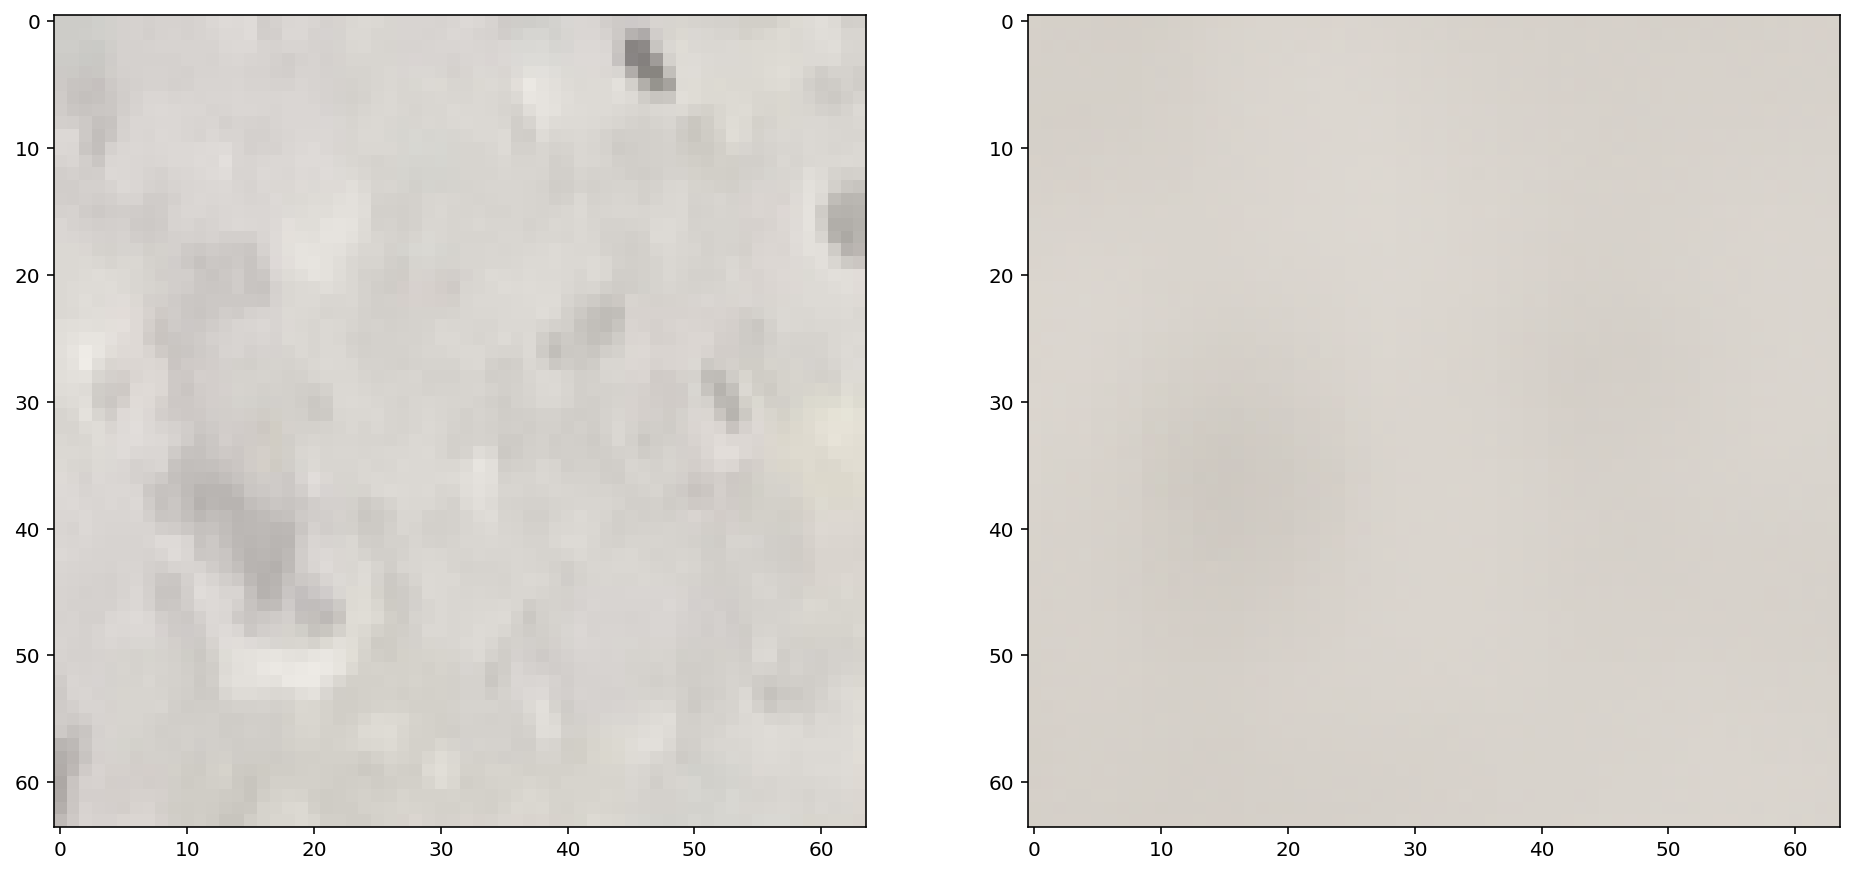

In [ ]:
idx = 821
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())
plt.show()

# Test on Normal Train Data

In [ ]:
normal_train = img_to_np(neg_train[:1000])
normal_train = normal_train.astype(np.float32) / 255

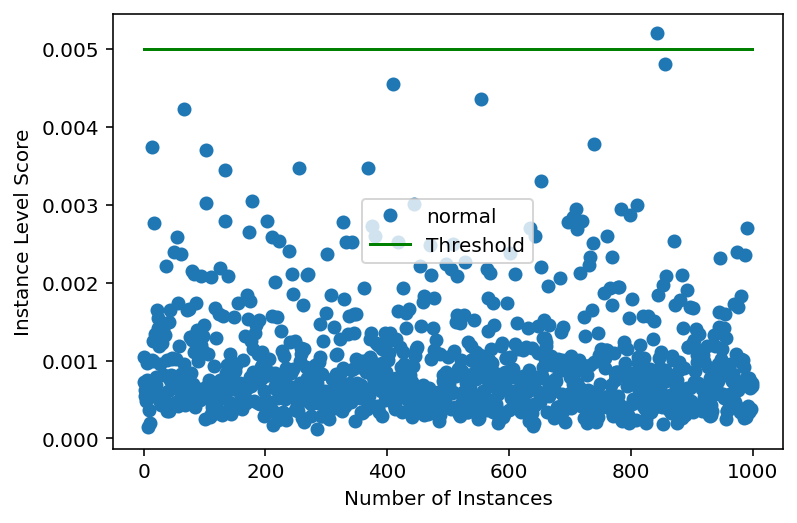

In [ ]:
od_preds = od.predict(
    normal_train,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(normal_train.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

In [ ]:
import pandas as pd


d_train = {'fileNm': neg_train[:1000], 'target': [0 for i in range(1000)], 'score': od_preds['data']['instance_score']}
df_train = pd.DataFrame(d_train)
df_train.head()

,fileNm,target,score
0,Negative/02686.jpg,0,0.000724
1,Negative/08259.jpg,0,0.001039
2,Negative/18833.jpg,0,0.000620
3,Negative/06155.jpg,0,0.000538
4,Negative/15767.jpg,0,0.000482


In [ ]:
df_train['pred'] = df_train['score'].map(lambda x: np.where(x >= od.threshold, 1, 0))
df_train.head()

,fileNm,target,score,pred
0,Negative/02686.jpg,0,0.000724,0
1,Negative/08259.jpg,0,0.001039,0
2,Negative/18833.jpg,0,0.000620,0
3,Negative/06155.jpg,0,0.000538,0
4,Negative/15767.jpg,0,0.000482,0


In [ ]:
from sklearn.metrics import accuracy_score, recall_score


train_acc = accuracy_score(y_true=df_train['target'], y_pred=df_train['pred'])
print(f'train accuracy: {train_acc}')

train accuracy: 0.999


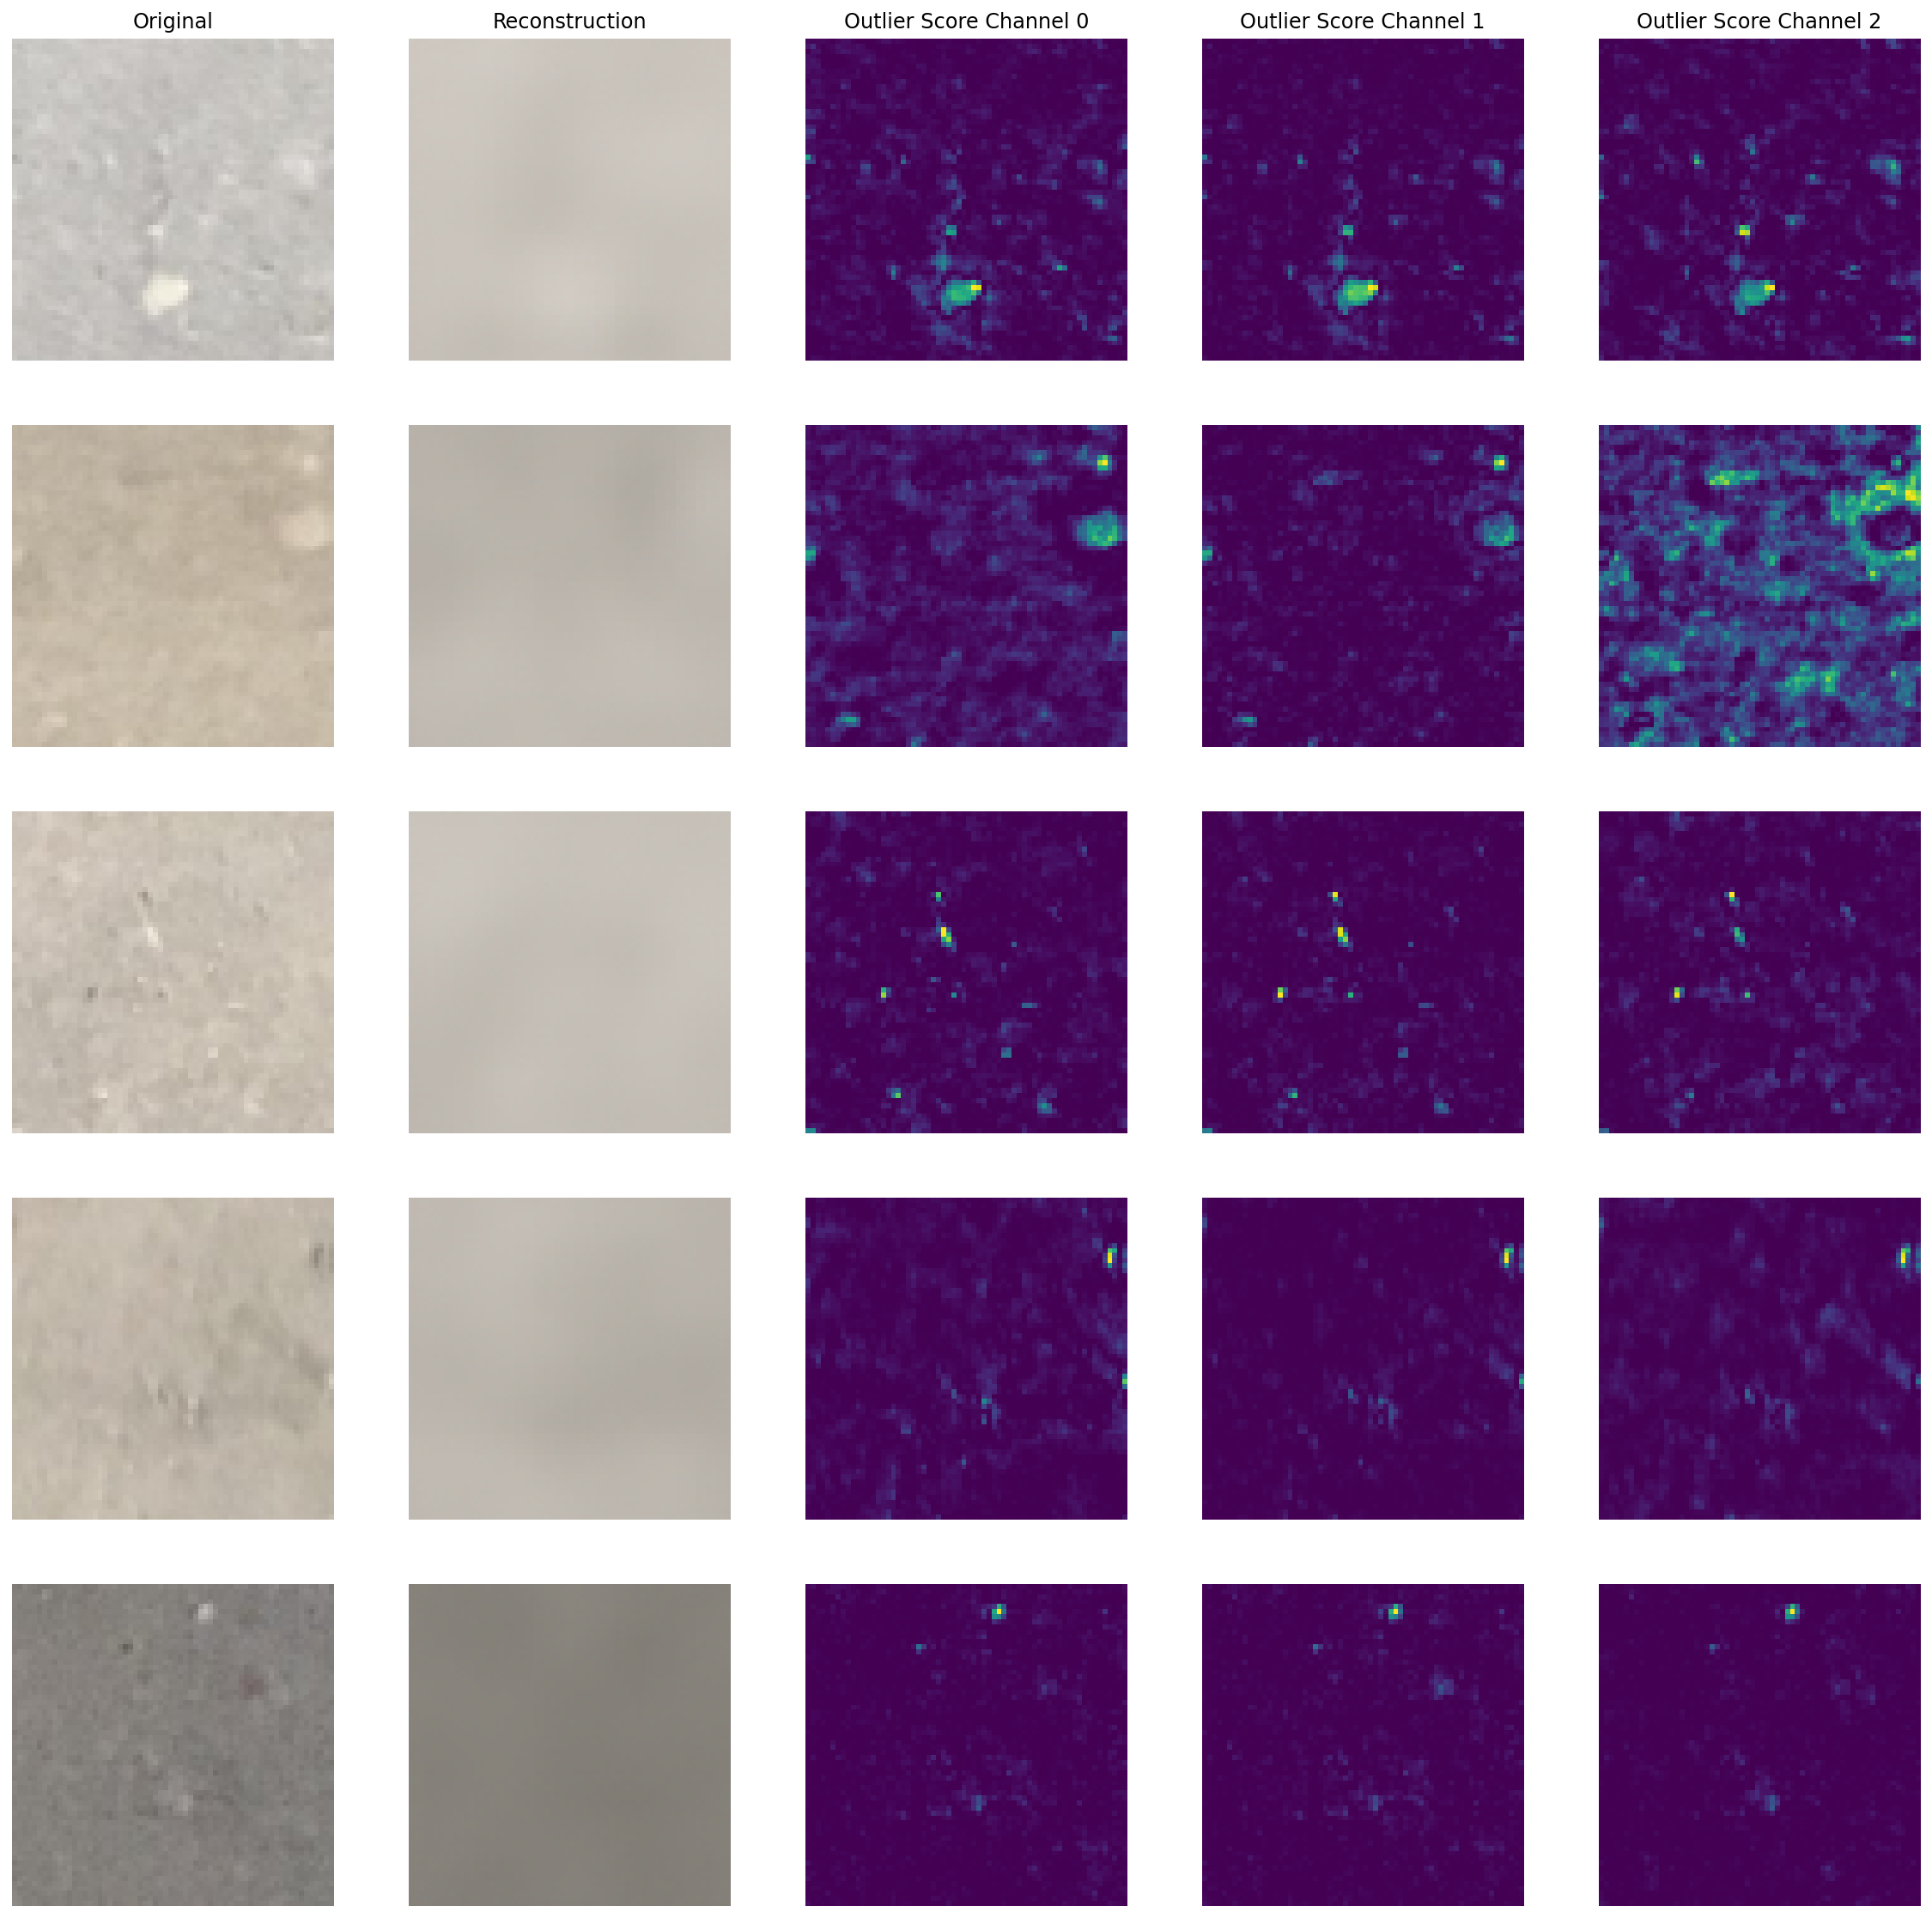

In [ ]:
x_recon = od.vae(normal_train).numpy()

plot_feature_outlier_image(
    od_preds,
    normal_train,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

# Test on Crack Images

In [ ]:
outlier_train = img_to_np(pos_train[:1000])
outlier_train = outlier_train.astype(np.float32) / 255

print(outlier_train.shape)

(1000, 64, 64, 3)


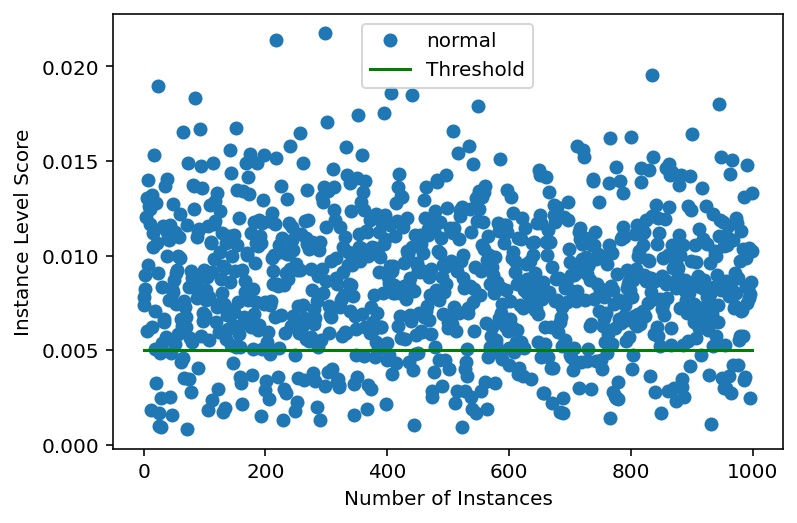

In [ ]:
od_preds = od.predict(
    outlier_train,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(outlier_train.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

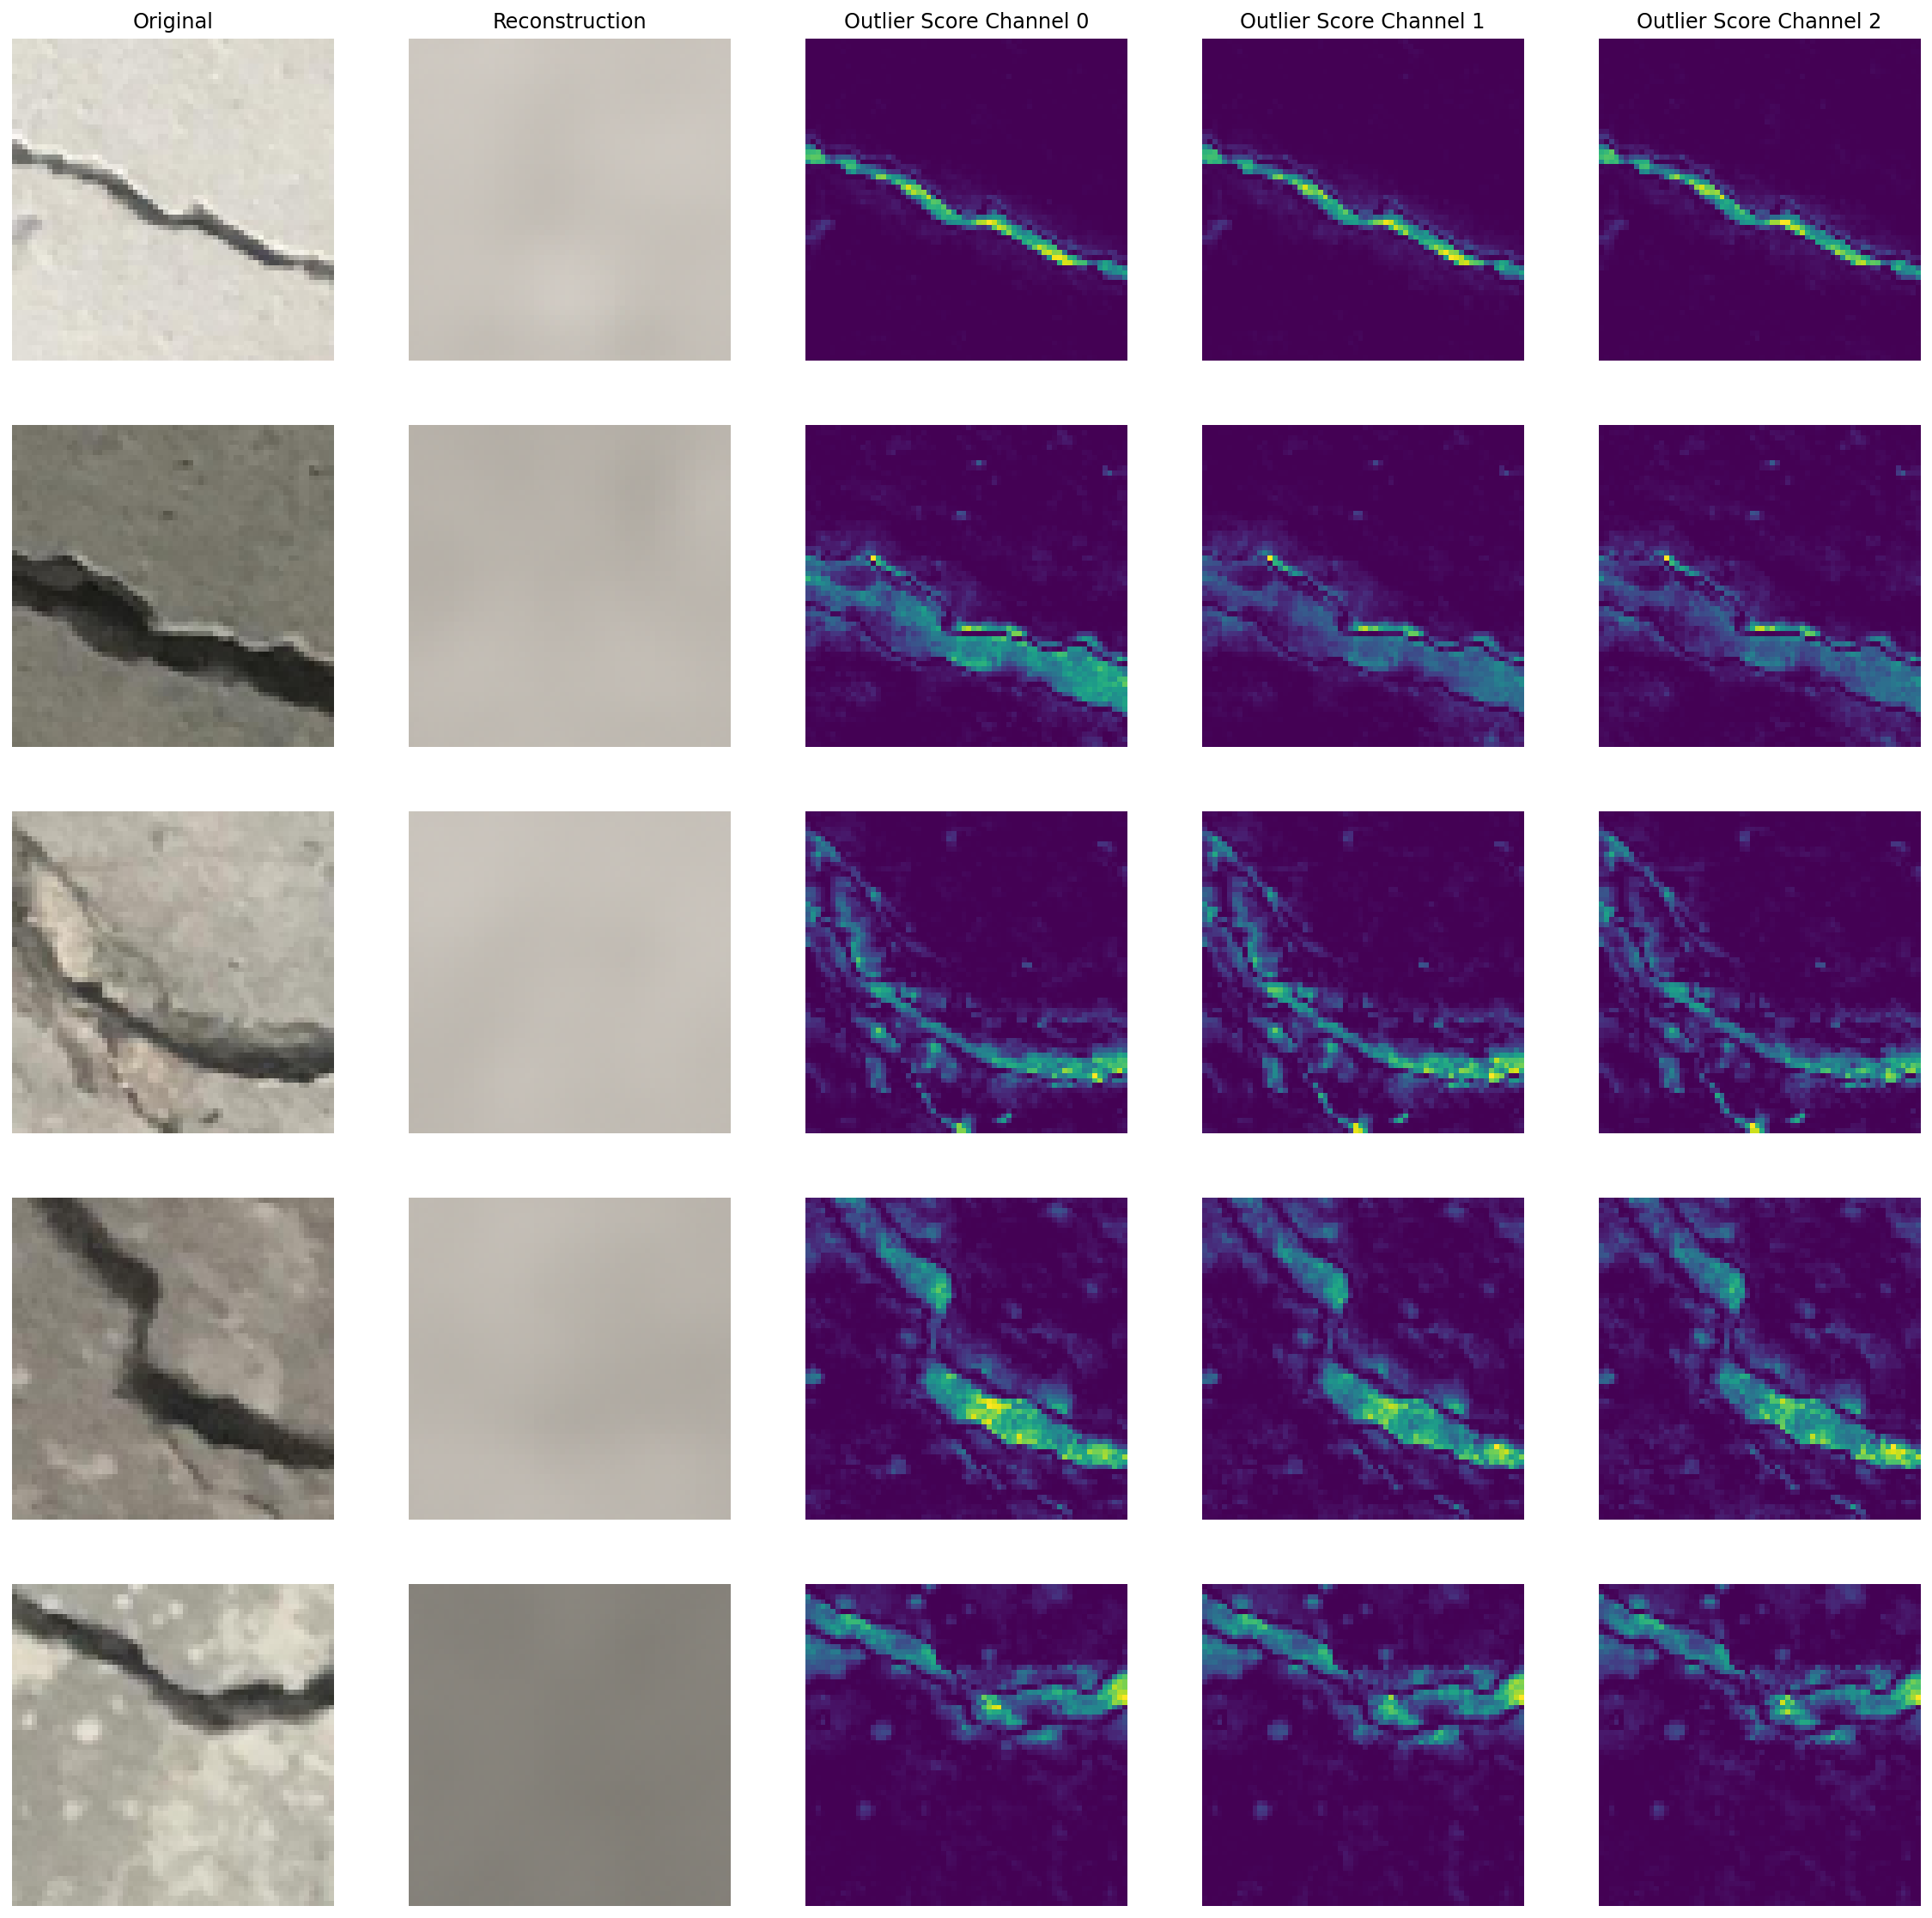

In [ ]:
plot_feature_outlier_image(
    od_preds,
    outlier_train,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

# Test on Validation Data and Optimize Threshold

In [ ]:
df_valid = pd.DataFrame({'fileNm': [*pos_val[:500], *neg_val[:500]]})
df_valid['target'] = df_valid['fileNm'].map(lambda x: np.where('Positive' in x, 1, 0))
df_valid

,fileNm,target
0,Positive/13956_1.jpg,1
1,Positive/18744_1.jpg,1
2,Positive/19326_1.jpg,1
3,Positive/12622_1.jpg,1
4,Positive/02312.jpg,1
...,...,...
995,Negative/18647.jpg,0
996,Negative/12048.jpg,0
997,Negative/10620.jpg,0
998,Negative/07510.jpg,0


In [ ]:
x_val = img_to_np(df_valid['fileNm'])
x_val = x_val.astype(np.float32) / 255

print(x_val.shape)

(1000, 64, 64, 3)


In [ ]:
od_preds = od.predict(
    x_val,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

df_valid['score'] = od_preds['data']['instance_score']
df_valid

,fileNm,target,score
0,Positive/00894.jpg,1,0.009175
1,Positive/06188.jpg,1,0.009685
2,Positive/04408.jpg,1,0.008833
3,Positive/04808.jpg,1,0.005719
4,Positive/08254.jpg,1,0.010121
...,...,...,...
995,Negative/18139.jpg,0,0.001178
996,Negative/18708.jpg,0,0.000140
997,Negative/09014.jpg,0,0.000827
998,Negative/11604.jpg,0,0.000685


In [ ]:
import plotly.express as px


fig = px.box(df_valid,
             x="target",
             y="score",
             color="target",
             notched=True,
             width=600,
             height=800)
fig.update_layout(title_text='<b>Box Plot of Instance Score</b>',
                  title_x=0.5)
fig.show()

In [ ]:
score_top = df_valid.query('target == 0')['score'].max()
score_bottom = df_valid.query('target == 1')['score'].min()
thresholds = np.linspace(score_bottom, score_top, 200)

d_preds = dict({})

for threshold in thresholds:
  d_preds[f'{threshold}'] = df_valid['score'].map(lambda x: np.where(x >= threshold, 1, 0)).tolist()

d_metrics = {'threshold': [], 'accuracy': [], 'recall': []}
y_true = df_valid['target']

for threshold in thresholds:
  y_pred = d_preds[f'{threshold}']
  d_metrics['threshold'].append(threshold)
  d_metrics['accuracy'].append(accuracy_score(y_true=y_true, y_pred=y_pred))
  d_metrics['recall'].append(recall_score(y_true=y_true, y_pred=y_pred))

df_metrics = pd.DataFrame(d_metrics)
df_metrics

,threshold,accuracy,recall
0,0.000859,0.783,1.000
1,0.000876,0.789,0.998
2,0.000892,0.793,0.998
3,0.000909,0.797,0.998
4,0.000926,0.803,0.998
...,...,...,...
195,0.004153,0.951,0.904
196,0.004170,0.950,0.902
197,0.004187,0.950,0.902
198,0.004203,0.950,0.902


In [ ]:
import plotly.graph_objects as go


fig = go.Figure()
fig.update_layout(width=600, height=600,
                  title_text='<b>The Relation Between Scores and Thresholds</b>',
                  yaxis=dict(title_text='Score'),
                  xaxis=dict(title_text='Threshold'))
fig.add_trace(go.Scatter(x=df_metrics['threshold'], y=df_metrics['accuracy'],
                    mode='lines',
                    name='Accuracy'))
fig.add_trace(go.Scatter(x=df_metrics['threshold'], y=df_metrics['recall'],
                    mode='lines',
                    name='Recall'))
fig.show()

In [ ]:
opt_idx = np.argmax(np.sum(df_metrics.drop(columns=['threshold']), axis=1))
opt_threshold = df_metrics.iloc[opt_idx]['threshold']
df_metrics.iloc[opt_idx]

threshold    0.002159
accuracy     0.962000
recall       0.982000
Name: 77, dtype: float64

# Test on Test Data

In [ ]:
df_test = pd.DataFrame({'fileNm': [*pos_test[:500], *neg_test[:500]]})
df_test['target'] = df_test['fileNm'].map(lambda x: np.where('Positive' in x, 1, 0))
df_test

,fileNm,target
0,Positive/18177_1.jpg,1
1,Positive/12636_1.jpg,1
2,Positive/00050.jpg,1
3,Positive/05932.jpg,1
4,Positive/06075.jpg,1
...,...,...
995,Negative/07378.jpg,0
996,Negative/10693.jpg,0
997,Negative/14868.jpg,0
998,Negative/02494.jpg,0


In [ ]:
od.threshold = opt_threshold

x_test = img_to_np([*pos_test[:500], *neg_test[:500]])
x_test = x_test.astype(np.float32) / 255

print(x_test.shape)

(1000, 64, 64, 3)


In [ ]:
od_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

df_test['score'] = od_preds['data']['instance_score']
df_test['pred'] = df_test['score'].map(lambda x: np.where(x >= od.threshold, 1, 0))
df_test

,fileNm,target,score,pred
0,Positive/18177_1.jpg,1,0.006306,1
1,Positive/12636_1.jpg,1,0.004941,1
2,Positive/00050.jpg,1,0.006147,1
3,Positive/05932.jpg,1,0.006246,1
4,Positive/06075.jpg,1,0.008809,1
...,...,...,...,...
995,Negative/07378.jpg,0,0.000438,0
996,Negative/10693.jpg,0,0.000216,0
997,Negative/14868.jpg,0,0.000438,0
998,Negative/02494.jpg,0,0.000943,0


In [ ]:
test_acc = accuracy_score(y_true=df_test['target'], y_pred=df_test['pred'])
test_recall = recall_score(y_true=df_test['target'], y_pred=df_test['pred'])

print(f'Test Accuracy: {test_acc}\nTest Recall: {test_recall}')

Test Accuracy: 0.955
Test Recall: 0.982


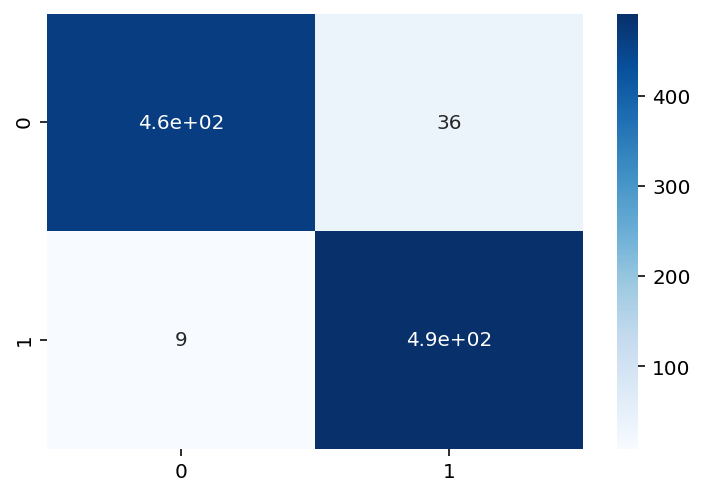

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cf_matrix = confusion_matrix(y_true=df_test['target'], y_pred=df_test['pred'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.show()

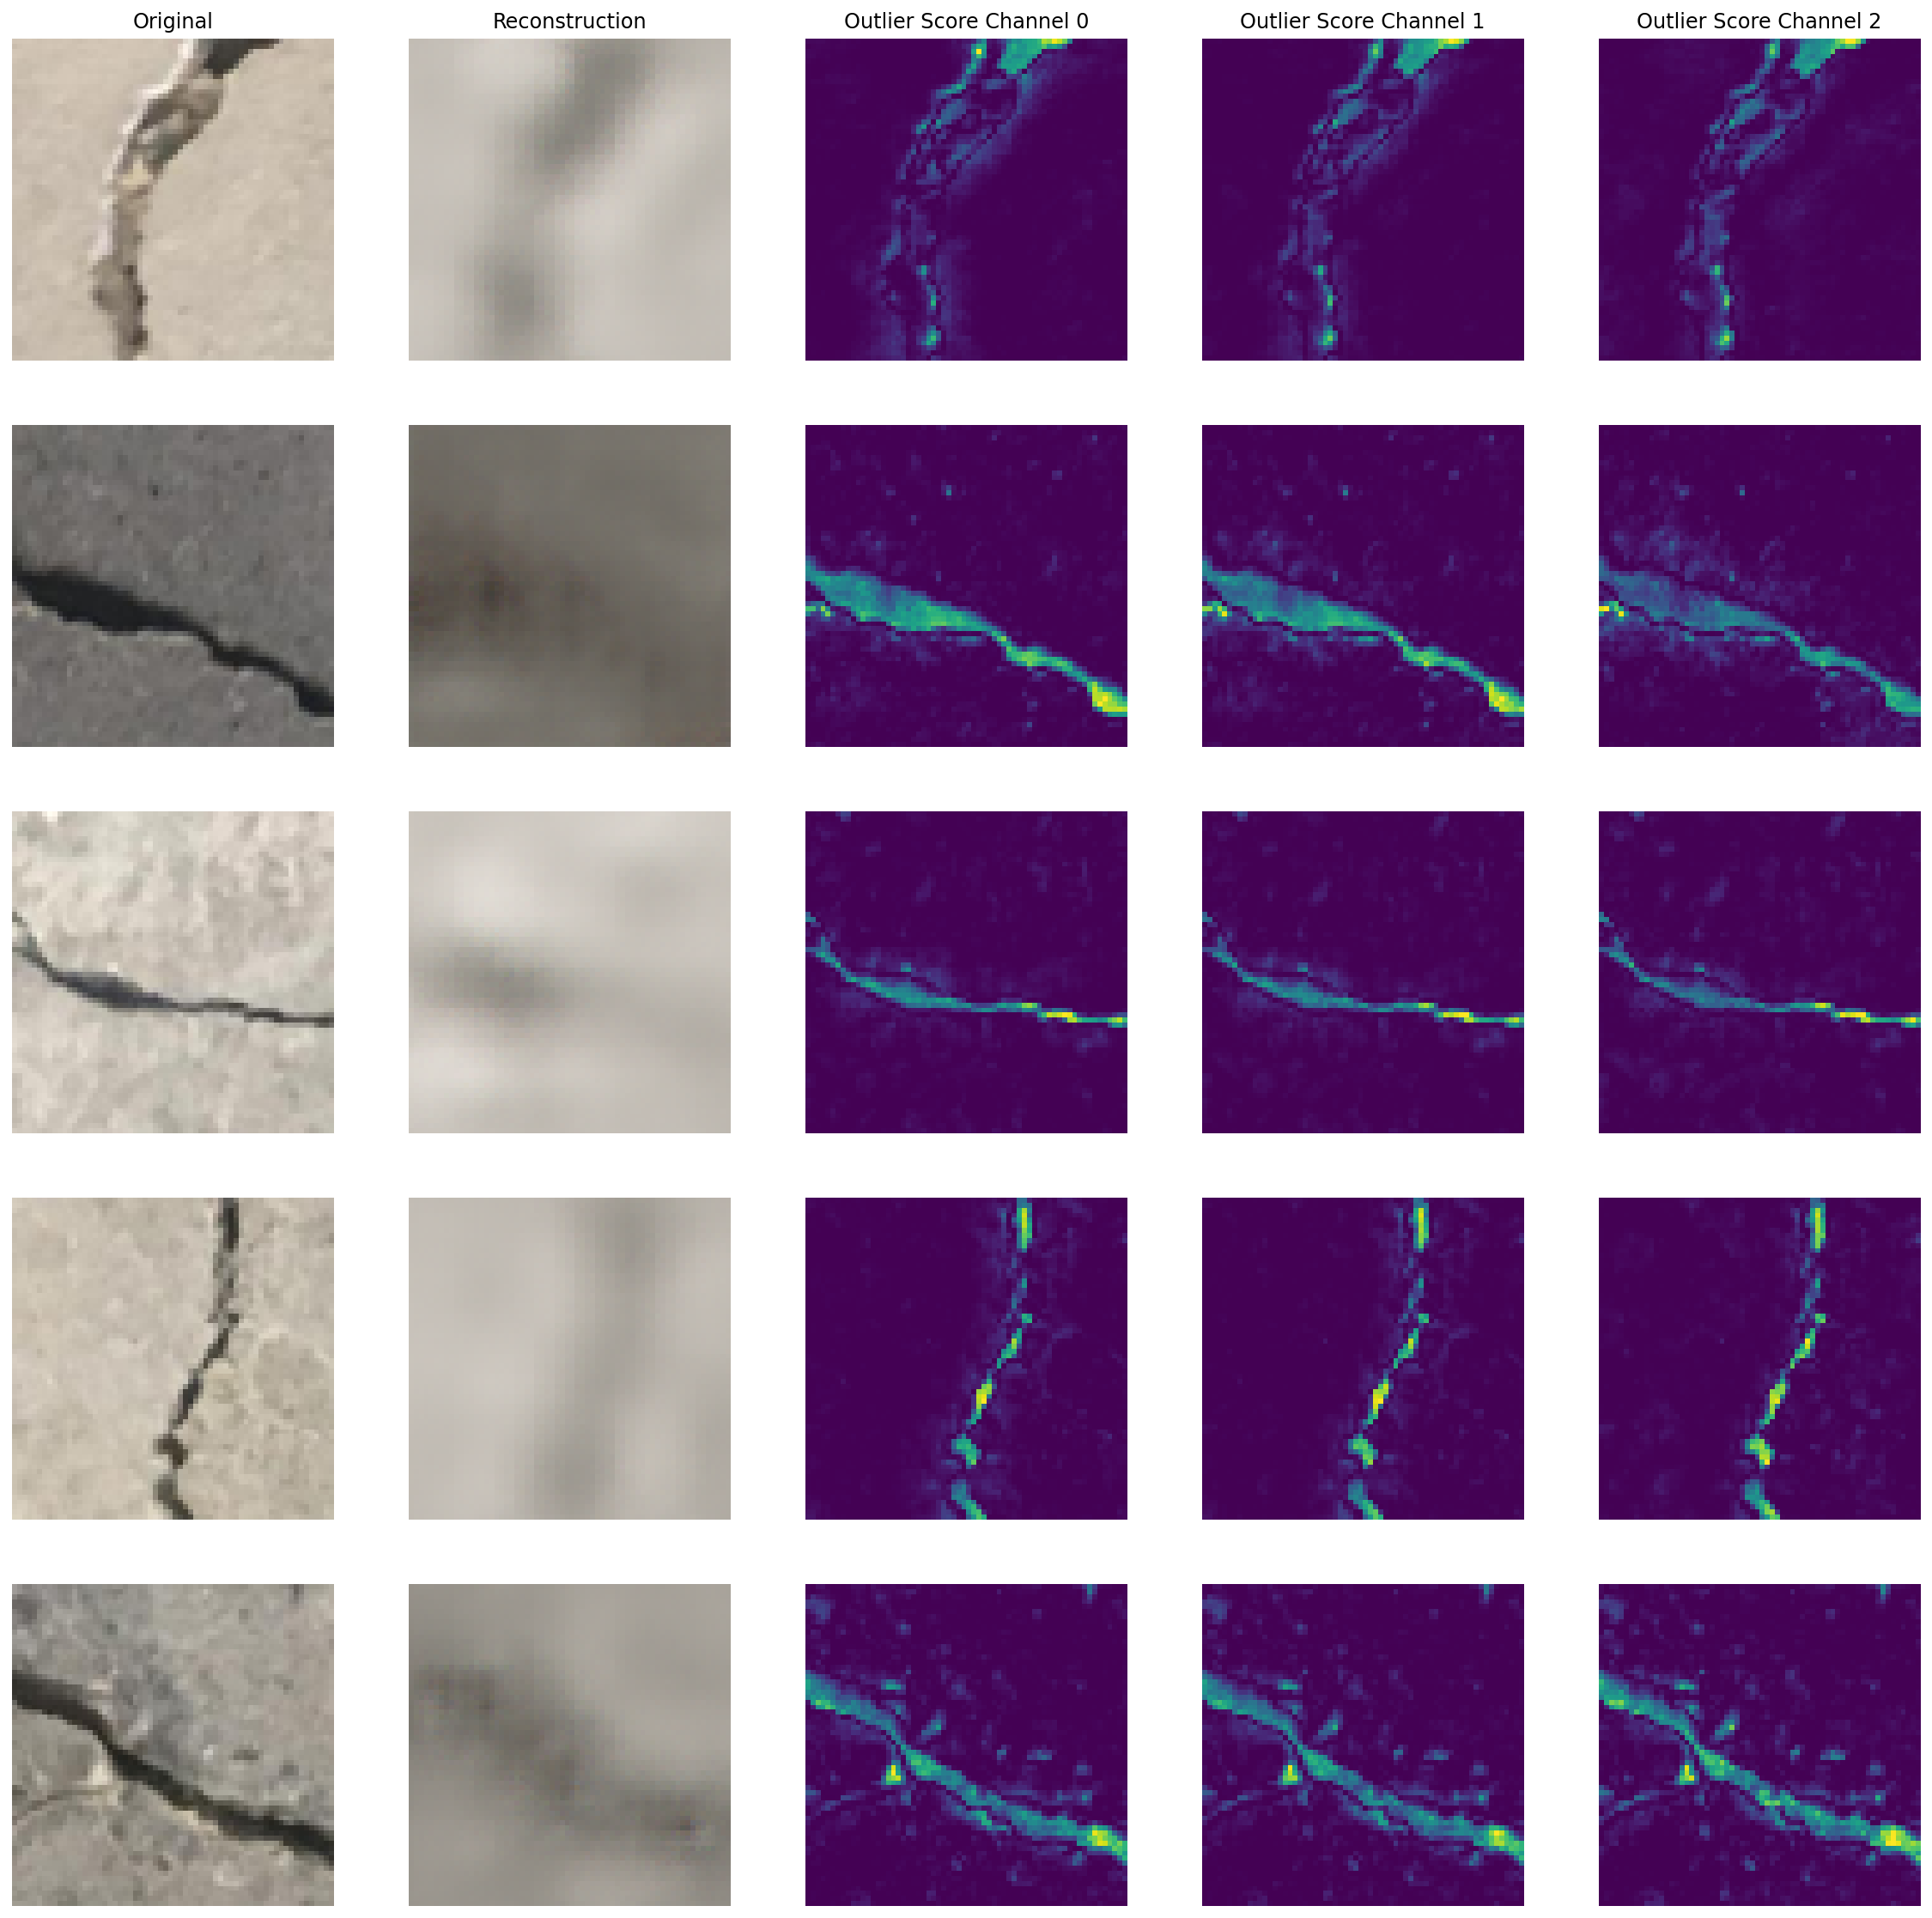

In [ ]:
x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

# Build Pipeline

# Test on Manuanlly Collected Images

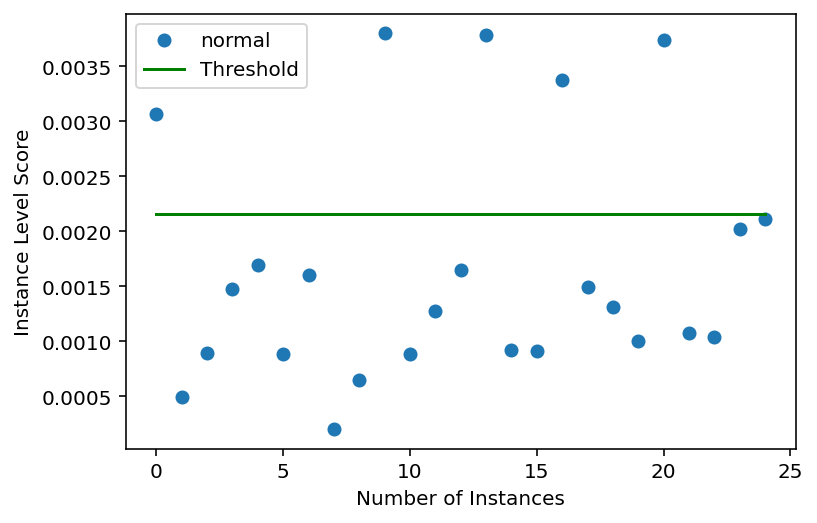

In [ ]:
od_preds = od.predict(
    neg_random,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(neg_random.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

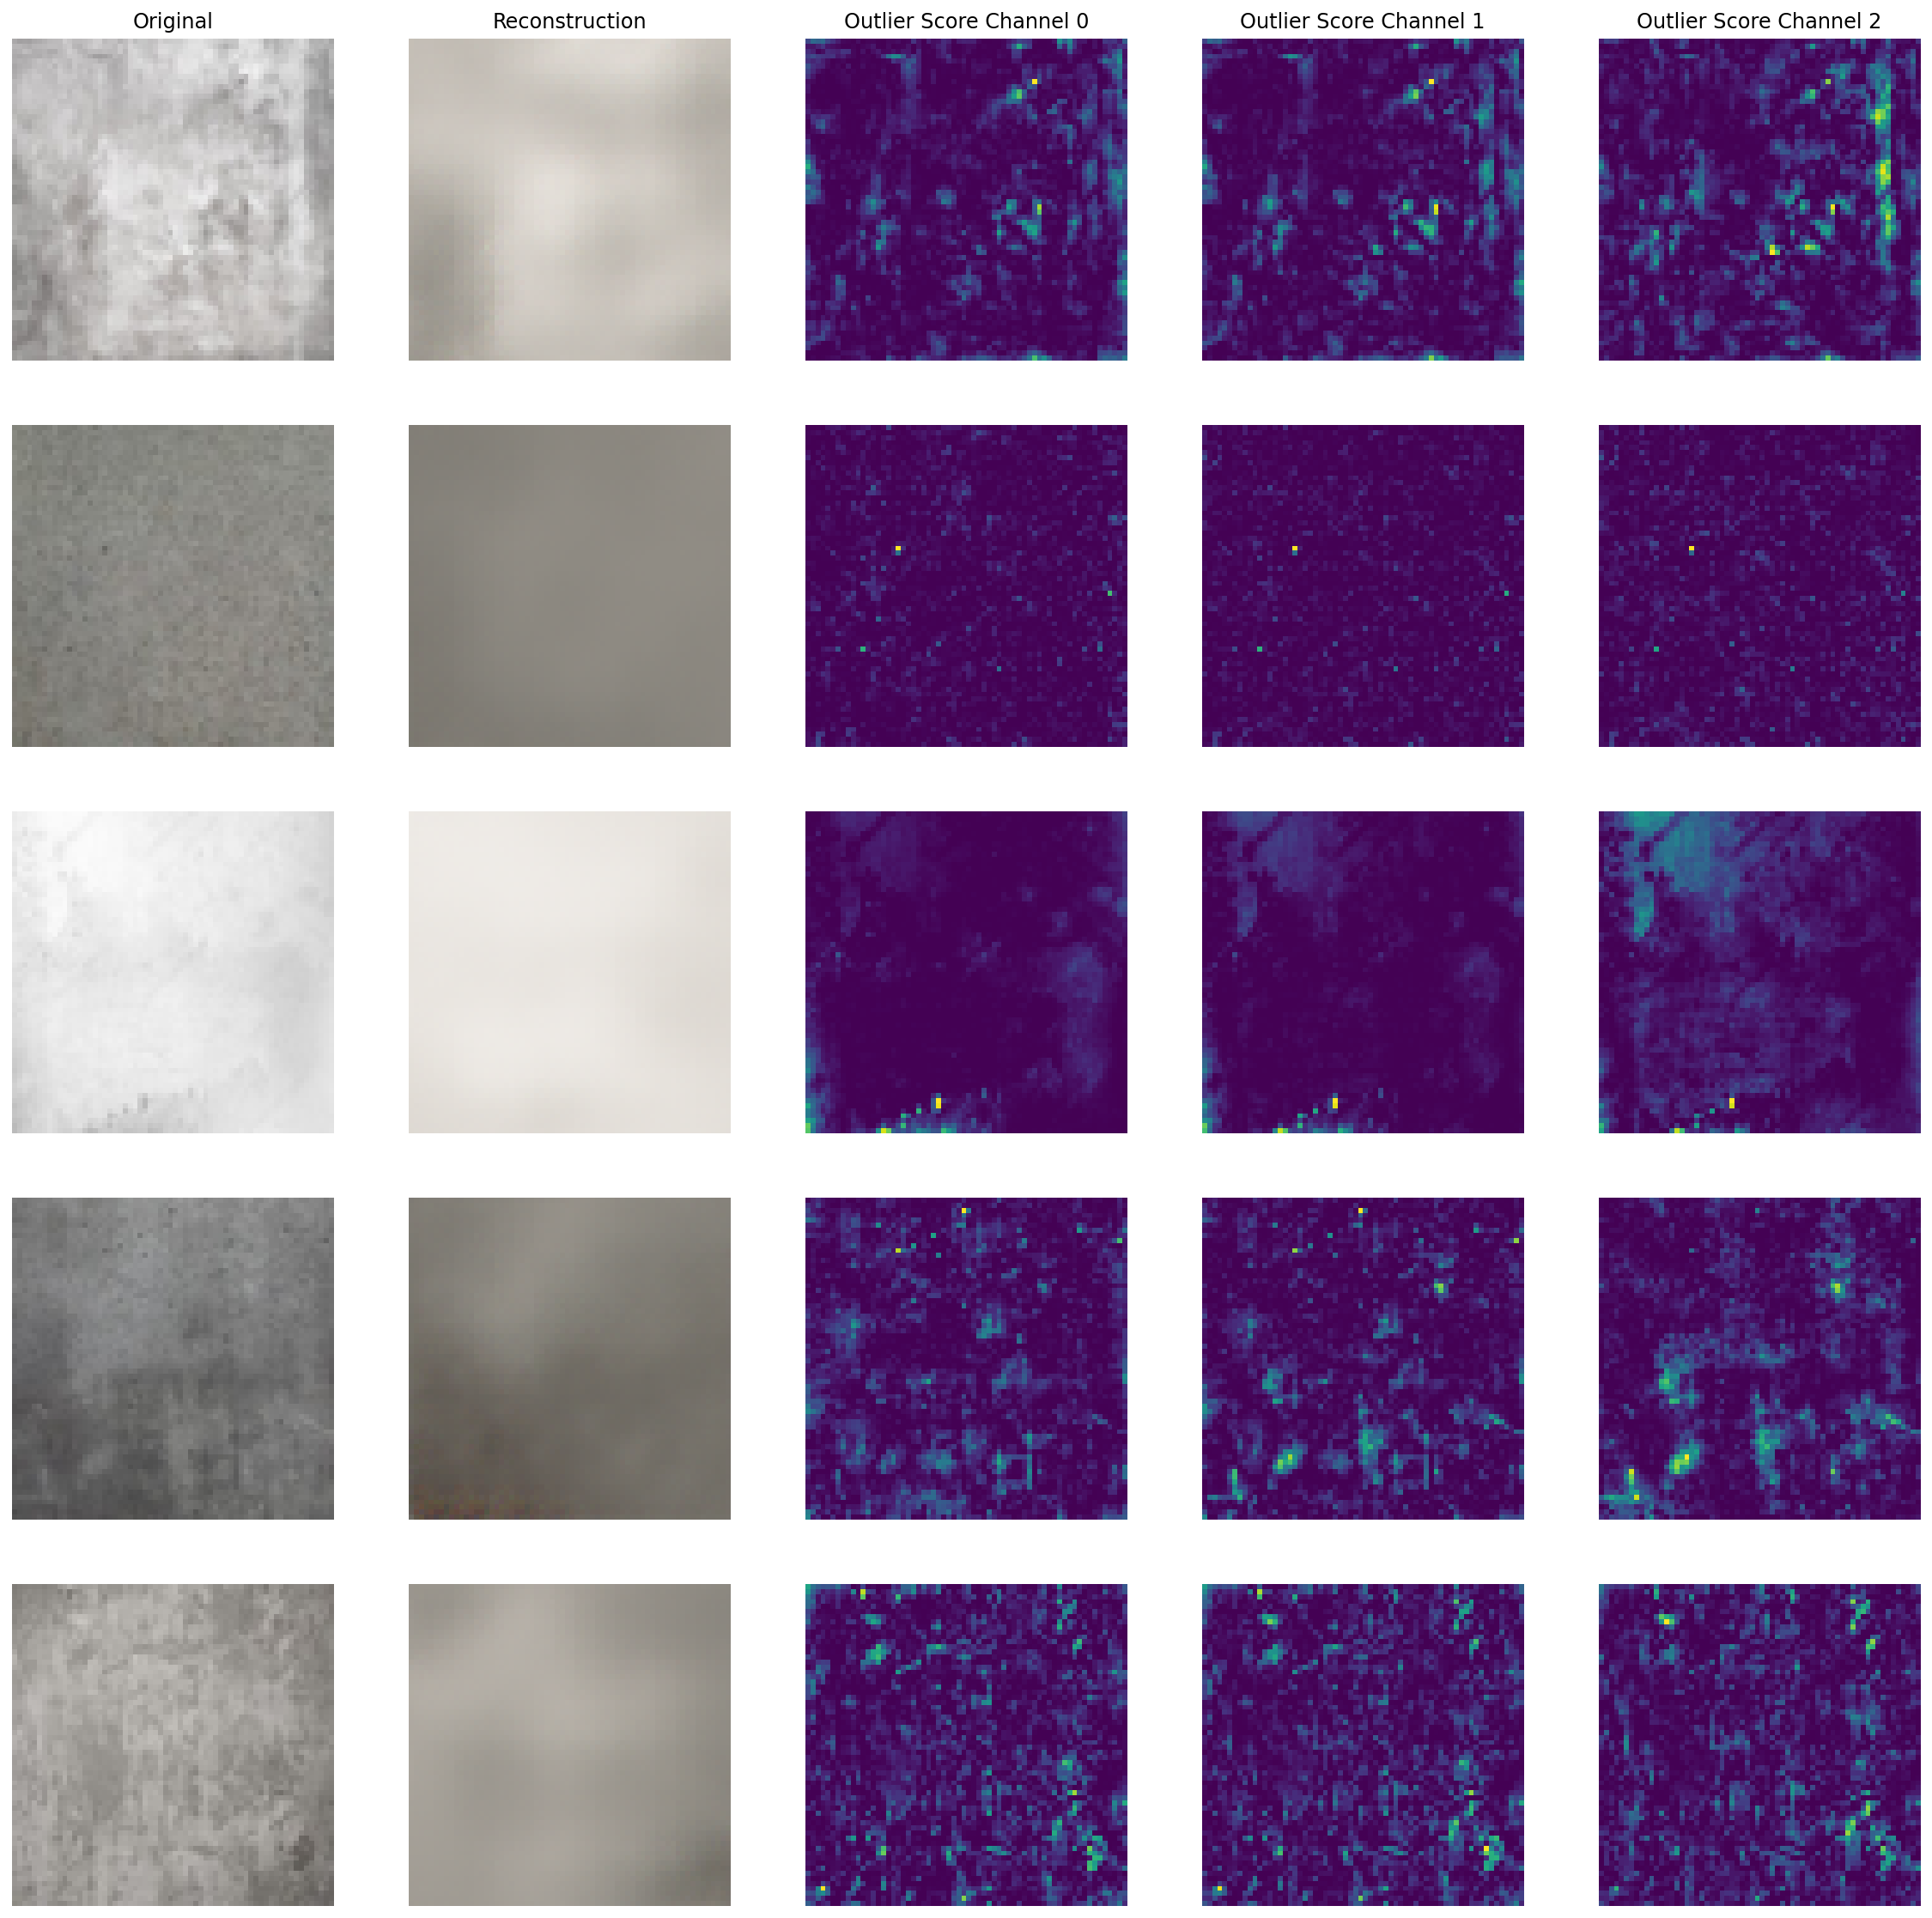

In [ ]:
x_recon = od.vae(neg_random).numpy()

plot_feature_outlier_image(
    od_preds,
    neg_random,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)

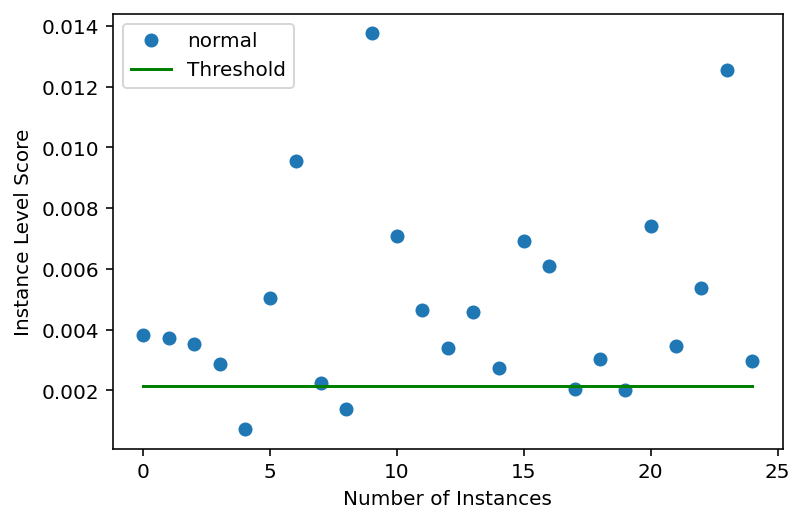

In [ ]:
od_preds = od.predict(
    pos_random,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(pos_random.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

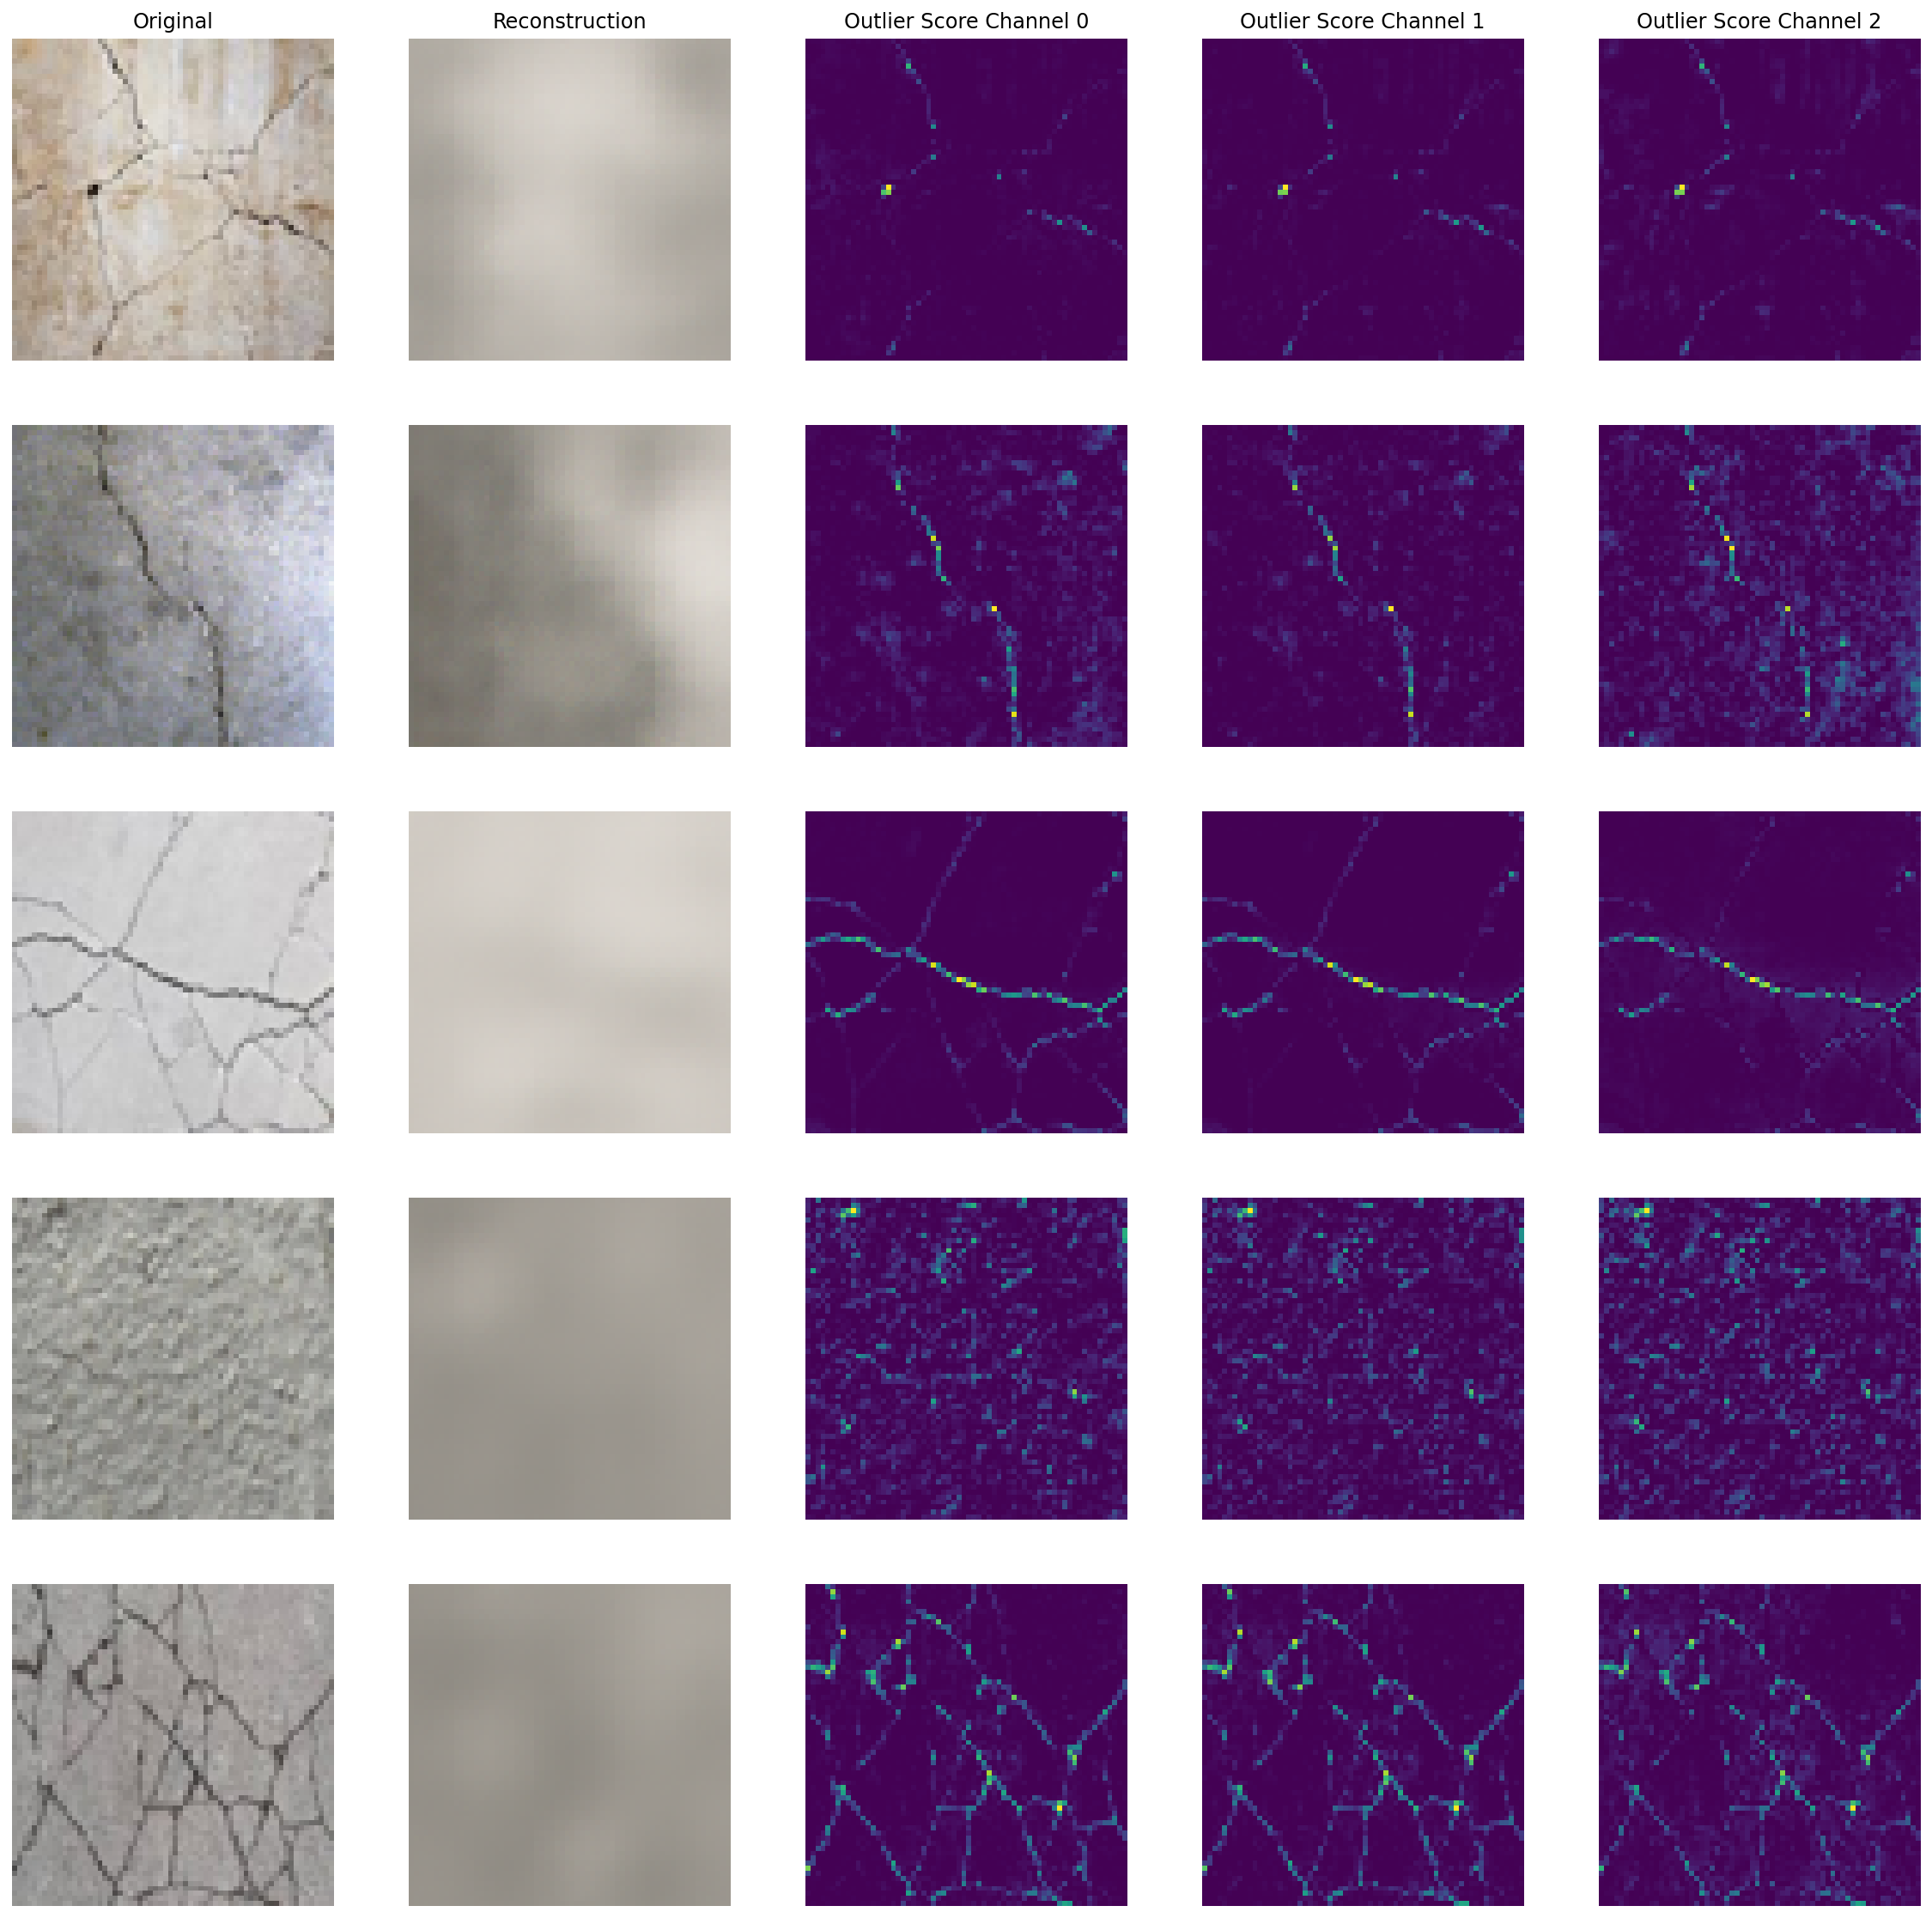

In [ ]:
x_recon = od.vae(pos_random).numpy()

plot_feature_outlier_image(
    od_preds,
    pos_random,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

In [ ]:
df_random = pd.DataFrame({'fileNm': [*pos_random_list, *neg_random_list]})
df_random['target'] = df_random['fileNm'].map(lambda x: np.where('Positive' in x, 1, 0))
df_random.head()

,fileNm,target
0,Positive_test/18.jpg,1
1,Positive_test/14.jpg,1
2,Positive_test/22.jpg,1
3,Positive_test/24.jpg,1
4,Positive_test/25.jpg,1


In [ ]:
x_random = img_to_np(df_random['fileNm'])
x_random = x_random.astype(np.float32) / 255
x_random.shape

(50, 64, 64, 3)

In [ ]:
od_preds = od.predict(
    x_random,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

df_random['score'] = od_preds['data']['instance_score']
df_random['pred'] = df_random['score'].map(lambda x: np.where(x >= od.threshold, 1, 0))

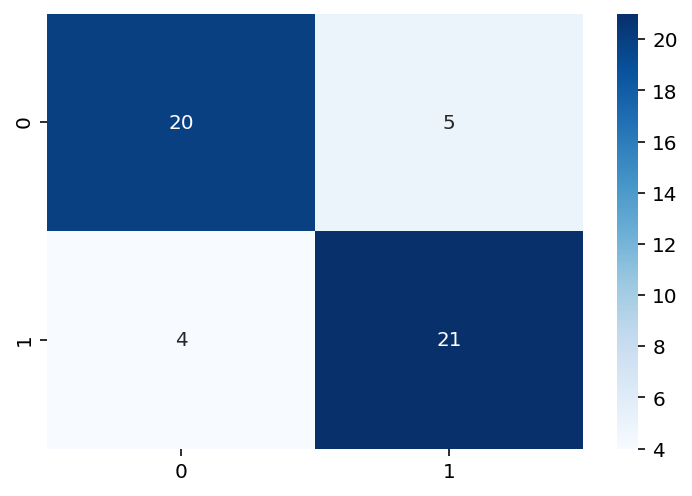

In [ ]:
y_true = df_random['target']
y_pred = df_random['pred']
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.show()

In [ ]:
random_acc = accuracy_score(y_true=y_true, y_pred=y_pred)
random_recall = recall_score(y_true=y_true, y_pred=y_pred)

print(f'Totally Unseen Data Accuracy: {random_acc}\nTotally Unseen Data Recall: {random_recall}')

Totally Unseen Data Accuracy: 0.82
Totally Unseen Data Recall: 0.84
